# Simulação de confinamentos usando Flood Fill
Utilizando Breadth-First Search (BFS)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import clear_output
import time


In [15]:
def make_donut_grid(n=31, r_inner=6, r_outer=13):
    """
    Cria um grid com:
      0 = célula livre
      1 = obstáculo (anel entre raios r_inner e r_outer)
    """
    grid = np.zeros((n, n), dtype=int)
    cx = cy = n // 2

    for i in range(n):
        for j in range(n):
            d = np.sqrt((i - cx)**2 + (j - cy)**2)
            # Agora SIM: apenas o anel é obstáculo
            if r_inner <= d <= r_outer:
                grid[i, j] = 1   # obstáculo

    return grid


In [16]:
def show_bfs(grid, dist, step):
    """
    Mostra o estado atual:
      - grid == 1 -> obstáculo
      - dist >= 0 -> distância BFS a partir da origem
      - dist == -1 em célula livre ainda não alcançada
    """
    clear_output(wait=True)

    # Começa com -1 em livres não visitadas; para visualização, usamos NaN
    img = dist.astype(float).copy()
    img[img < 0] = np.nan  # livres não visitadas ficam vazias
    # Obstáculos também como NaN, mas vamos marcar eles à parte
    obstacles = (grid == 1)

    plt.figure(figsize=(5, 5))

    # Distâncias (ondas) em colormap
    im = plt.imshow(img, origin="lower", cmap="coolwarm")
    plt.colorbar(im, fraction=0.046, pad=0.04, label="Distância BFS")

    # Contorno dos obstáculos em preto
    ys, xs = np.where(obstacles)
    plt.scatter(xs, ys, s=10, c="black")

    plt.title(f"BFS – passo {step}")
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [17]:
def bfs_wave(grid, start, pause=0.05):
    """
    Executa BFS a partir de 'start' em um grid:
      grid == 0 -> livre
      grid == 1 -> obstáculo

    Mostra a “onda” se expandindo e, ao final,
    diz se o ponto está confinado (onda não chegou em nenhuma borda).
    """
    n, m = grid.shape
    sx, sy = start

    if grid[sx, sy] == 1:
        raise ValueError("Ponto inicial está em um obstáculo!")

    # -1 = ainda não visitado
    dist = np.full((n, m), -1, dtype=int)
    dist[sx, sy] = 0

    fila = deque()
    fila.append((sx, sy))

    step = 0
    show_bfs(grid, dist, step)  # mostra estado inicial

    while fila:
        x, y = fila.popleft()

        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy

            if 0 <= nx < n and 0 <= ny < m:
                if grid[nx, ny] == 0 and dist[nx, ny] == -1:
                    dist[nx, ny] = dist[x, y] + 1
                    fila.append((nx, ny))

        step += 1
        show_bfs(grid, dist, step)
        time.sleep(pause)

    # Verifica se alguma borda foi alcançada
    reached_border = (
        np.any(dist[0, :]  >= 0) or
        np.any(dist[-1, :] >= 0) or
        np.any(dist[:, 0]  >= 0) or
        np.any(dist[:, -1] >= 0)
    )

    if reached_border:
        print("NÃO está em confinamento: a onda chegou em alguma borda.")
    else:
        print("Está em CONFINAMENTO: a onda não alcançou nenhuma borda.")

    return dist


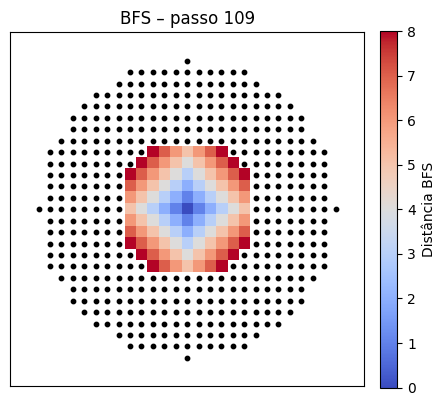

Está em CONFINAMENTO: a onda não alcançou nenhuma borda.


In [22]:
# Grid em forma de anel (confinado)
grid_confinado = make_donut_grid()

# Origem no centro
start = (grid_confinado.shape[0] // 2, grid_confinado.shape[1] // 2)

dist_confinado = bfs_wave(grid_confinado, start, pause=0.05)


# Simulação de navegação do carrinho
Utilizando Breadth-First Search (BFS)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from IPython.display import clear_output
import time


In [23]:
def make_carrinho_grid(n=31, r_inner=10, r_outer=13):
    """
    Cria um grid no estilo do carrinho:
      0 = não explorado
      1 = livre
      2 = obstáculo
      3 = carrinho (posição atual)

    - Anel de obstáculos 2 entre r_inner e r_outer.
    - Interior do anel = 1 (livre), com o carrinho 3 no centro.
    - Um bloco de células 0 (não exploradas) dentro do anel.
    - Um obstáculo 2 na direção “reta” do alvo 0, para obrigar o desvio.
    """
    grid = np.zeros((n, n), dtype=int)
    cx = cy = n // 2

    # 1) Anel de obstáculos
    for i in range(n):
        for j in range(n):
            d = np.sqrt((i - cx)**2 + (j - cy)**2)
            if r_inner <= d <= r_outer:
                grid[i, j] = 2   # obstáculo

    # 2) Interior do anel como área livre (1)
    for i in range(n):
        for j in range(n):
            d = np.sqrt((i - cx)**2 + (j - cy)**2)
            if d < r_inner - 1:   # um pouco antes do anel
                grid[i, j] = 1

    # 3) Carrinho no centro
    grid[cx, cy] = 3

    # 4) Bloco de '0' (área não explorada) dentro do anel, à direita do carrinho
    #    (primeiro marcamos como '1' lá em cima, aqui sobrescrevemos para '0')
    for dx in range(-3, 4):
        for dy in range(3, 8):
            x, y = cx + dx, cy + dy
            if 0 <= x < n and 0 <= y < n:
                # só convertendo livres (1) em não exploradas (0)
                if grid[x, y] == 1:
                    grid[x, y] = 0

    # 5) Obstáculo '2' na direção reta do alvo (entre o carrinho e o bloco de '0')
    #    Por exemplo, uma "parede" vertical curta logo à frente à direita
    for dx in range(-1, 2):
        x = cx + dx
        y = cy + 2  # coluna logo à direita do carrinho
        if grid[x, y] != 3:       # não sobrescreve o carrinho
            grid[x, y] = 2

    return grid

grid = make_carrinho_grid()


In [24]:
def mostrar_grid(grid, passo=None, caminho=None):
    """
    Mostra o grid com imshow.
      0 = não explorado
      1 = livre
      2 = obstáculo
      3 = carrinho
    Se 'caminho' for passado, plota os pontos do caminho por cima.
    """
    clear_output(wait=True)
    plt.figure(figsize=(5, 5))
    im = plt.imshow(grid, origin="lower")  # colormap padrão
    plt.colorbar(im, fraction=0.046, pad=0.04)

    if caminho is not None:
        xs = [p[1] for p in caminho]
        ys = [p[0] for p in caminho]
        plt.plot(xs, ys, 'k--', linewidth=2)

    if passo is not None:
        plt.title(f"Passo {passo}")
    else:
        plt.title("Mapa do carrinho (0/1/2/3)")

    plt.xticks([])
    plt.yticks([])
    plt.show()


In [29]:
from collections import deque
import numpy as np

def encontrar_pos_carrinho(grid):
    pos = np.argwhere(grid == 3)
    if len(pos) == 0:
        raise ValueError("Não há carrinho (3) no grid.")
    return tuple(pos[0])  # (x, y)


def bfs_menor_rota_ate_zero(grid):
    """
    BFS em 4 direções, no estilo do carrinho:
      - Pode andar em células 0 ou 1 (não explorado ou livre).
      - Não pode atravessar células 2 (obstáculo).
      - 3 é o ponto de partida.
    Retorna:
      caminho = lista de coordenadas (x,y) desde depois da origem até o '0' mais próximo
    ou None se não houver '0' alcançável.
    """
    n, m = grid.shape
    sx, sy = encontrar_pos_carrinho(grid)

    # listas de listas
    dist   = [[-1 for _ in range(m)] for _ in range(n)]
    parent = [[None for _ in range(m)] for _ in range(n)]

    q = deque()
    q.append((sx, sy))
    dist[sx][sy] = 0

    alvo = None

    while q:
        x, y = q.popleft()

        # Se chegou num '0', esse é o mais próximo (BFS)
        if grid[x, y] == 0:
            alvo = (x, y)
            break

        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < n and 0 <= ny < m:
                if grid[nx, ny] != 2 and dist[nx][ny] == -1:  # <<< repare nos [nx][ny]
                    dist[nx][ny] = dist[x][y] + 1              # <<< aqui também
                    parent[nx][ny] = (x, y)
                    q.append((nx, ny))

    if alvo is None:
        return None  # não existe '0' alcançável

    # Reconstrói caminho do alvo até a origem
    caminho = []
    cur = alvo
    while cur != (sx, sy):
        caminho.append(cur)
        cx, cy = cur
        cur = parent[cx][cy]

    caminho.reverse()
    return caminho


In [30]:
def simular_carrinho(grid, pause=0.2):
    """
    - Calcula a menor rota até um '0' (não explorado).
    - Mostra o mapa e move o carrinho passo a passo.
    - Cada posição antiga do carrinho vira '1' (livre visitado).
    - A célula final (que era '0') vira '3' no fim.
    """
    g = grid.copy()
    caminho = bfs_menor_rota_ate_zero(g)

    if caminho is None:
        print("Nenhum '0' alcançável a partir da posição atual.")
        mostrar_grid(g)
        return g

    # Mostra mapa inicial com o caminho desenhado
    mostrar_grid(g, passo=0, caminho=caminho)
    time.sleep(pause)

    for passo, (x, y) in enumerate(caminho, start=1):
        # posição atual do carrinho
        rx, ry = np.argwhere(g == 3)[0]
        # posição antiga vira livre visitada
        g[rx, ry] = 1
        # nova posição vira carrinho
        g[x, y] = 3

        mostrar_grid(g, passo=passo, caminho=caminho)
        time.sleep(pause)

    print("Carrinho chegou ao '0' mais próximo.")
    return g


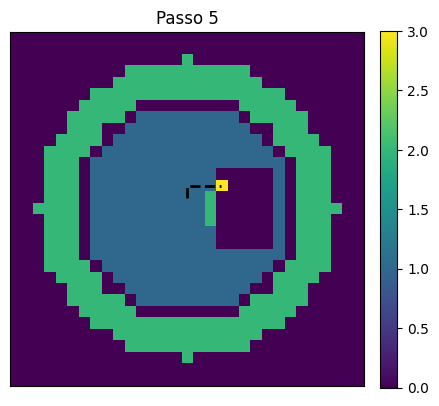

Carrinho chegou ao '0' mais próximo.


In [42]:
grid = make_carrinho_grid()
grid_final = simular_carrinho(grid, pause=0.15)
